In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np
import os
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import optuna


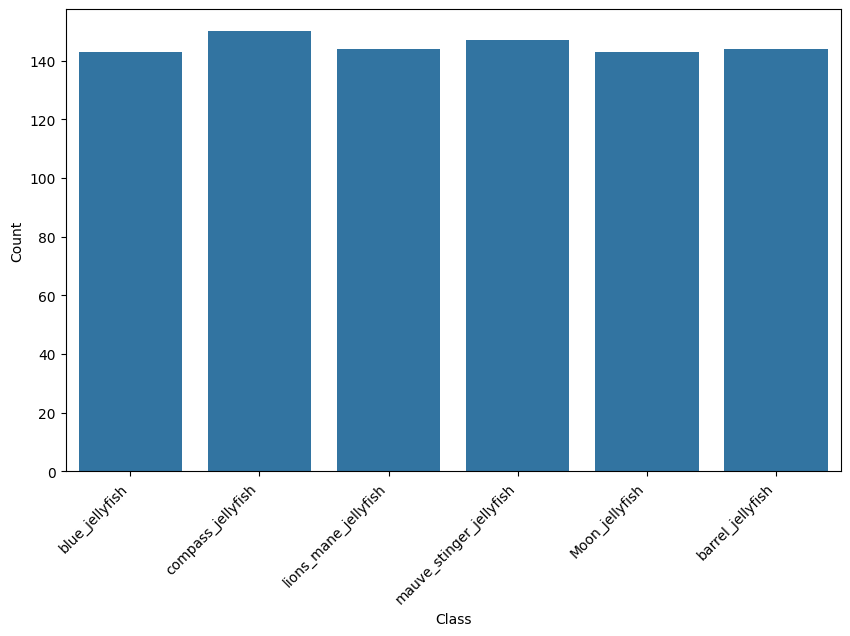

In [15]:
def load_data(data_directory):
    images = []
    labels = []
    classes = []
    label_encoder = LabelEncoder()

    for class_name in os.listdir(data_directory):
        class_path = os.path.join(data_directory, class_name)
        classes.append(class_name)

        for filename in os.listdir(class_path):
            if filename.endswith(('.jpg', '.png', '.jpeg')):  # 이미지 파일만 필터링
                filepath = os.path.join(class_path, filename)
                img = cv2.imread(filepath)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                    img = cv2.resize(img, (224, 224))
                    img = img / 255.0
                    images.append(img)
                    labels.append(class_name)

    images = np.array(images)
    labels = label_encoder.fit_transform(labels)

    return images, labels, classes

# 데이터 로드 및 시각화
data_directory = './jellyfish_data'
images, labels, classes = load_data(data_directory)

# 클래스 분포 시각화
plt.figure(figsize=(10, 6))
sns.countplot(x=[classes[label] for label in labels])  
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

# 학습 및 테스트 세트 분할
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [ ]:
# 1. 데이터셋 로드 함수 (이전에 작성한 load_data 함수 사용)
data_directory = './jellyfish_data'
images, labels, classes = load_data(data_directory)

# 학습 및 검증 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# 2. 데이터 증강 설정
train_datagen = ImageDataGenerator(
    rotation_range=45,        # 최대 30도 회전
    width_shift_range=0.3,    # 가로 방향 이동
    height_shift_range=0.3,   # 세로 방향 이동
    shear_range=0.3,          # 전단 변환
    zoom_range=0.3,           # 확대/축소
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],     # 좌우 반전
    fill_mode='nearest'       # 빈 부분을 가장 가까운 값으로 채움
)

val_datagen = ImageDataGenerator()  # 검증 데이터에는 증강 적용하지 않음

# 3. 증강된 데이터 제너레이터 생성
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

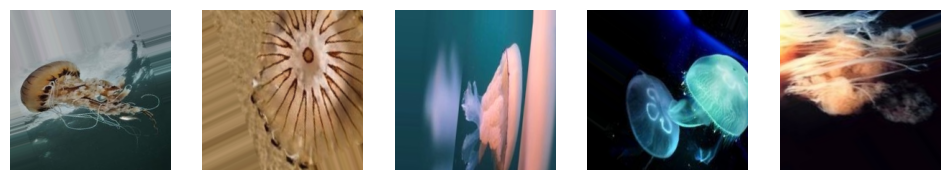

In [17]:
# 증강된 데이터 샘플 보기 함수
def plot_augmented_images(generator, n_images=5):
    # 제너레이터에서 증강된 이미지와 레이블 가져오기
    images, labels = next(generator)
    
    plt.figure(figsize=(12, 8))
    for i in range(n_images):
        ax = plt.subplot(1, n_images, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

# train_generator에서 샘플 이미지 보기
plot_augmented_images(train_generator)

In [27]:
# 1. 데이터셋 로드 및 분할
data_directory = './jellyfish_data'
images, labels, classes = load_data(data_directory)
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# 2. Optuna Objective 함수 정의
def objective(trial):
    # 하이퍼파라미터 설정
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-3)
    fine_tune_at = trial.suggest_int('fine_tune_at', 50, 150)

    # EfficientNet 모델 설정
    input_shape = (224, 224, 3)
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    # 분류 레이어 추가
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(len(classes), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # 모델 컴파일
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # 콜백 설정
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint('optuna_efficient.keras', monitor='val_loss', save_best_only=True)

    # 초기 학습
    model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    # Fine-Tuning 설정
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:  # Fine-Tuning 기준 레이어 설정
        layer.trainable = False

    # Fine-Tuning 학습
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate * 0.1),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=5,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    # 검증 데이터 평가
    _, accuracy = model.evaluate(val_generator, verbose=0)
    return accuracy

# 3. Optuna 스터디 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# 4. 최적 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")



[I 2024-11-15 14:29:31,908] A new study created in memory with name: no-name-23cb29d4-e52d-46bd-ba72-8bfb1469745a
C:\Users\envym\AppData\Local\Temp\ipykernel_12916\3972408386.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
C:\Users\envym\AppData\Local\Temp\ipykernel_12916\3972408386.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-3)
[I 2024-11-15 14:37:29,329] Trial 0 finished with value: 0.18857142329216003 and parameters: {'dropout_rate': 0.483544571876056, 'learning_rate': 0.000279354855811616, 'fine_tune_at': 110}. Best is trial 0 with value: 0.18

Best trial:
  Value: 0.19428572058677673
  Params:
    dropout_rate: 0.3741230725794854
    learning_rate: 0.0006017784347566871
    fine_tune_at: 57


In [28]:
# Optuna에서 얻은 최적의 하이퍼파라미터 값
best_params = study.best_trial.params
dropout_rate = best_params['dropout_rate']
learning_rate = best_params['learning_rate']
fine_tune_at = best_params['fine_tune_at']

# 최적의 하이퍼파라미터로 EfficientNet 모델 설정
input_shape = (224, 224, 3)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False  # 전이 학습을 위해 초기에는 가중치 고정

# 분류 레이어 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(dropout_rate)(x)
output = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# 초기 학습 단계
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('final_best_efficient.keras', monitor='val_loss', save_best_only=True)

# 초기 학습
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, checkpoint]
)

# Fine-Tuning
base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:  # 최적 Fine-Tuning 시작 레이어
    layer.trainable = False

# Fine-Tuning 단계 컴파일 및 학습
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate * 0.1),  # 낮은 학습률로 Fine-Tuning
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, checkpoint]
)

# 최종 평가
loss, accuracy = model.evaluate(val_generator)
print(f"Final Validation Accuracy: {accuracy * 100:.2f}%")


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.1886 - loss: 1.9640 - val_accuracy: 0.1657 - val_loss: 1.8557
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.1716 - loss: 1.8635 - val_accuracy: 0.1429 - val_loss: 1.8176
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.1502 - loss: 1.8768 - val_accuracy: 0.1714 - val_loss: 1.8652
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.1686 - loss: 1.8721 - val_accuracy: 0.1943 - val_loss: 1.7998
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.1606 - loss: 1.8571 - val_accuracy: 0.1657 - val_loss: 1.8305
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.1584 - loss: 1.8475 - val_accuracy: 0.1657 - val_loss: 1.8094
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.1530 - loss: 1.8509 - val_accuracy: 0.1657 - val_loss: 1.8188
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.1334 - loss: 1.8256 - val_accuracy: 0.1429 - val_loss:

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


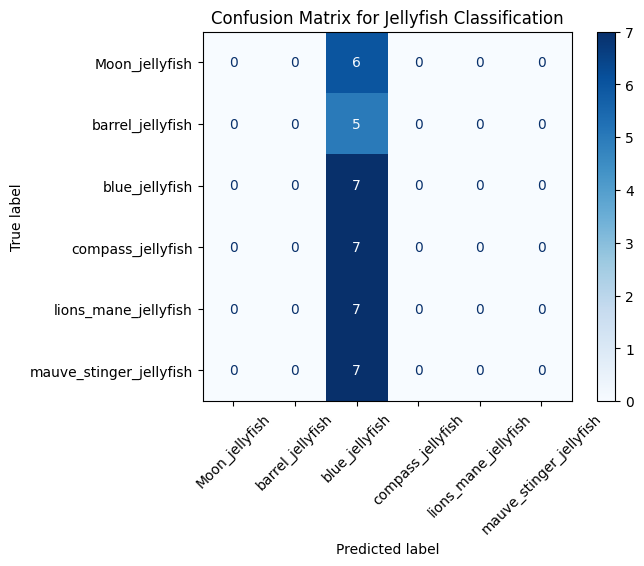

In [29]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 검증 데이터 예측
val_predictions = model.predict(val_data)
val_pred_labels = np.argmax(val_predictions, axis=1)
val_true_labels = val_data.classes  # 실제 라벨

# Confusion Matrix 생성
conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)
class_names = list(val_data.class_indices.keys())  # 클래스 이름 가져오기

# Confusion Matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix for Jellyfish Classification")
plt.show()
